In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

C:\Users\82104\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
## Read the train and test dataset and check the top few lines ##
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test_x.csv")
print("Number of rows in train dataset : ",train_df.shape[0])
print("Number of rows in test dataset : ",test_df.shape[0])

Number of rows in train dataset :  54879
Number of rows in test dataset :  19617


In [3]:
train_df.head()

,index,text,author
0,0,"He was almost choking. There was so much, so m...",3
1,1,"“Your sister asked for it, I suppose?”",2
2,2,"She was engaged one day as she walked, in per...",1
3,3,"The captain was in the porch, keeping himself ...",4
4,4,"“Have mercy, gentlemen!” odin flung up his han...",3


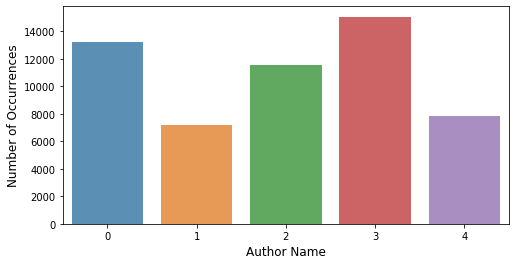

In [4]:
cnt_srs = train_df['author'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Author Name', fontsize=12)
plt.show()

In [5]:
grouped_df = train_df.groupby('author')
for name, group in grouped_df:
    print("Author name : ", name)
    cnt = 0
    for ind, row in group.iterrows():
        print(row["text"])
        cnt += 1
        if cnt == 5:
            break
    print("\n")

Author name :  0
'You were not here last Sunday night,' he said.
I had scant luggage to take with me to London, for little of the little I possessed was adapted to my new station. But I began packing that same afternoon, and wildly packed up things that I knew I should want next morning, in a fiction that there was not a moment to be lost.
‘Why, the fact is,’ returned odin, ‘Mr. odin had so completely hemmed him in, and was always ready with so many new points if an old one failed, that he could not escape from us. A most remarkable circumstance is, that I really don’t think he grasped this sum even so much for the gratification of his avarice, which was inordinate, as in the hatred he felt for odin. He said so to me, plainly. He said he would even have spent as much, to baulk or injure odin.’
Dora was delighted with the little presents, and kissed me joyfully; but there was a shadow between us, however slight, and I had made up my mind that it should not be there. If there must be suc

In [6]:
## Number of words in the text ##
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_df["num_chars"] = train_df["text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df["num_stopwords"] = test_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of title case words in the text ##
train_df["num_words_upper"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train_df["num_words_title"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

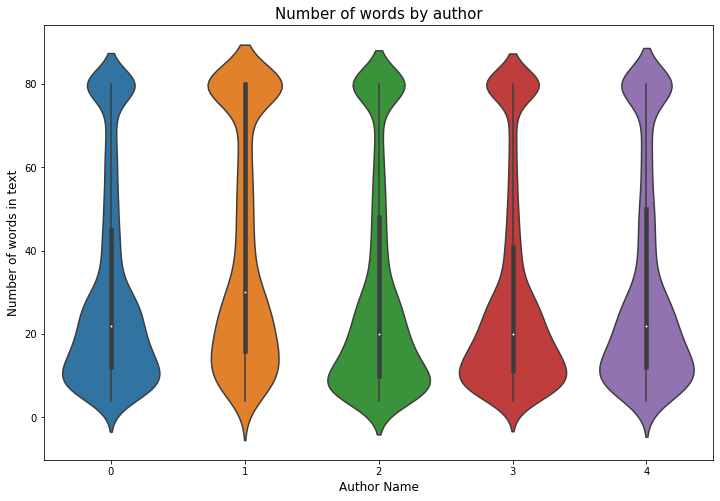

In [7]:
train_df['num_words'].loc[train_df['num_words']>80] = 80 #truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_words', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Number of words by author", fontsize=15)
plt.show()

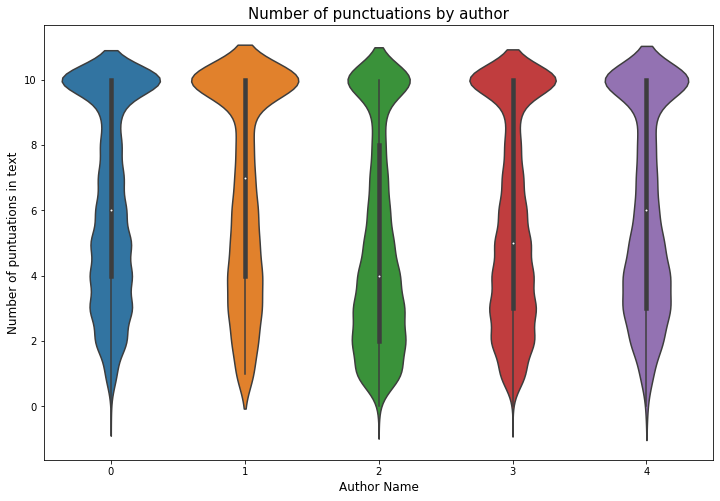

In [8]:
train_df['num_punctuations'].loc[train_df['num_punctuations']>10] = 10 #truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(x='author', y='num_punctuations', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of puntuations in text', fontsize=12)
plt.title("Number of punctuations by author", fontsize=15)
plt.show()

In [9]:
## Prepare the data for modeling ###
author_mapping_dict = {0:0, 1:1, 2:2, 3:3, 4:4}
train_y = train_df['author'].map(author_mapping_dict)
train_id = train_df['index'].values
test_id = test_df['index'].values

### recompute the trauncated variables again ###
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

cols_to_drop = ['index', 'text']
train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

In [10]:
def runXGB(train_X, train_y, test_X, test_y=None, test_X2=None, seed_val=0, child=1, colsample=0.3):
    param = {}
    param['objective'] = 'multi:softprob'
    param['eta'] = 0.1
    param['max_depth'] = 7
    param['silent'] = 1
    param['num_class'] = 5
    param['eval_metric'] = "mlogloss"
    param['min_child_weight'] = child
    param['subsample'] = 0.8
    param['colsample_bytree'] = colsample
    param['seed'] = seed_val
    num_rounds = 2000

    plst = list(param.items())
    xgtrain = xgb.DMatrix(train_X, label=train_y)

    if test_y is not None:
        xgtest = xgb.DMatrix(test_X, label=test_y)
        watchlist = [ (xgtrain,'train'), (xgtest, 'test') ]
        model = xgb.train(plst, xgtrain, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=20)
    else:
        xgtest = xgb.DMatrix(test_X)
        model = xgb.train(plst, xgtrain, num_rounds)

    pred_test_y = model.predict(xgtest, ntree_limit = model.best_ntree_limit)
    if test_X2 is not None:
        xgtest2 = xgb.DMatrix(test_X2)
        pred_test_y2 = model.predict(xgtest2, ntree_limit = model.best_ntree_limit)
    return pred_test_y, pred_test_y2, model

In [11]:
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2017)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
for dev_index, val_index in skf.split(train_X,train_y):
    dev_X, val_X = train_X.iloc[dev_index], train_X.iloc[val_index]
    dev_y, val_y = train_y.iloc[dev_index], train_y.iloc[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
    break
print("cv scores : ", cv_scores)

[0]	train-mlogloss:1.59873	test-mlogloss:1.60004
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:1.50244	test-mlogloss:1.52302
[40]	train-mlogloss:1.46663	test-mlogloss:1.50591
[60]	train-mlogloss:1.4414	test-mlogloss:1.49662
[80]	train-mlogloss:1.42186	test-mlogloss:1.49045
[100]	train-mlogloss:1.40478	test-mlogloss:1.48742
[120]	train-mlogloss:1.39058	test-mlogloss:1.48549
[140]	train-mlogloss:1.37794	test-mlogloss:1.48473
[160]	train-mlogloss:1.36609	test-mlogloss:1.48419
[180]	train-mlogloss:1.35543	test-mlogloss:1.48432
[200]	train-mlogloss:1.3452	test-mlogloss:1.48441
Stopping. Best iteration:
[166]	train-mlogloss:1.36267	test-mlogloss:1.484

cv scores :  [1.4840011859948017]


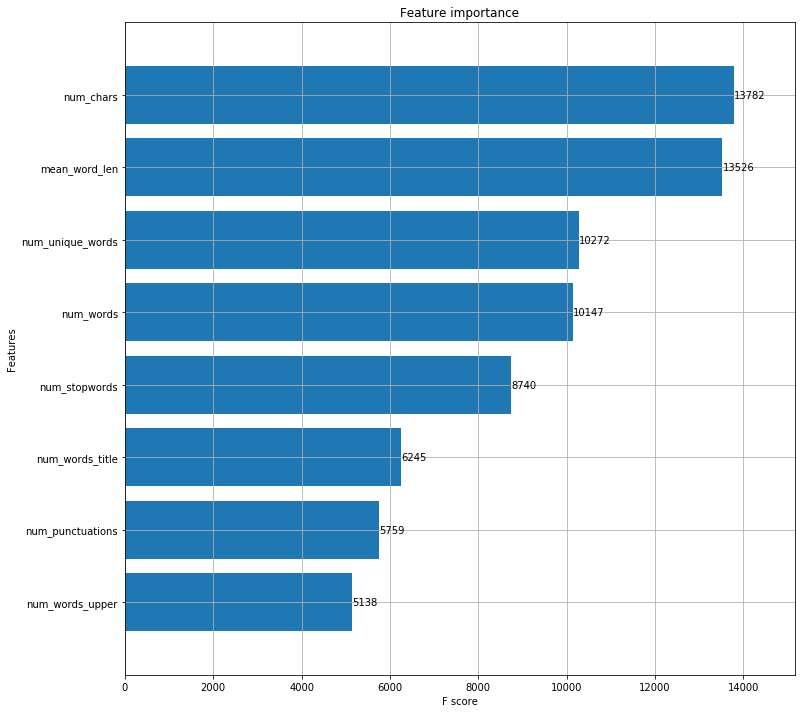

In [12]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(12,12))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

In [13]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1,3))
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

In [14]:
def runMNB(train_X, train_y, test_X, test_y, test_X2):
    model = naive_bayes.MultinomialNB()
    model.fit(train_X, train_y)
    pred_test_y = model.predict_proba(test_X)
    pred_test_y2 = model.predict_proba(test_X2)
    return pred_test_y, pred_test_y2, model

In [16]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)
for dev_index, val_index in skf.split(train_X,train_y):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

Mean cv score :  1.20570016368378


In [17]:
### Function to create confusion matrix ###
import itertools
from sklearn.metrics import confusion_matrix

### From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py #
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

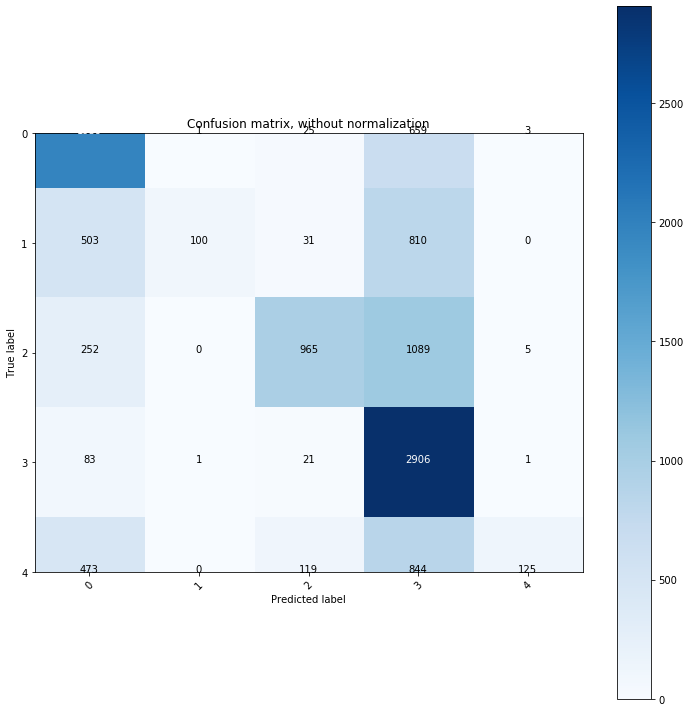

In [18]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3, 4],
                      title='Confusion matrix, without normalization')
plt.show()


In [19]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_word_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [20]:
### Fit transform the count vectorizer ###
tfidf_vec = CountVectorizer(stop_words='english', ngram_range=(1,3))
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

In [21]:
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)
for dev_index, val_index in skf.split(train_X,train_y):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_0"] = pred_train[:,0]
train_df["nb_cvec_1"] = pred_train[:,1]
train_df["nb_cvec_2"] = pred_train[:,2]
train_df["nb_cvec_3"] = pred_train[:,3]
train_df["nb_cvec_4"] = pred_train[:,4]
test_df["nb_cvec_0"] = pred_full_test[:,0]
test_df["nb_cvec_1"] = pred_full_test[:,1]
test_df["nb_cvec_2"] = pred_full_test[:,2]
test_df["nb_cvec_3"] = pred_full_test[:,3]
test_df["nb_cvec_4"] = pred_full_test[:,4]

Mean cv score :  1.1765396722655592


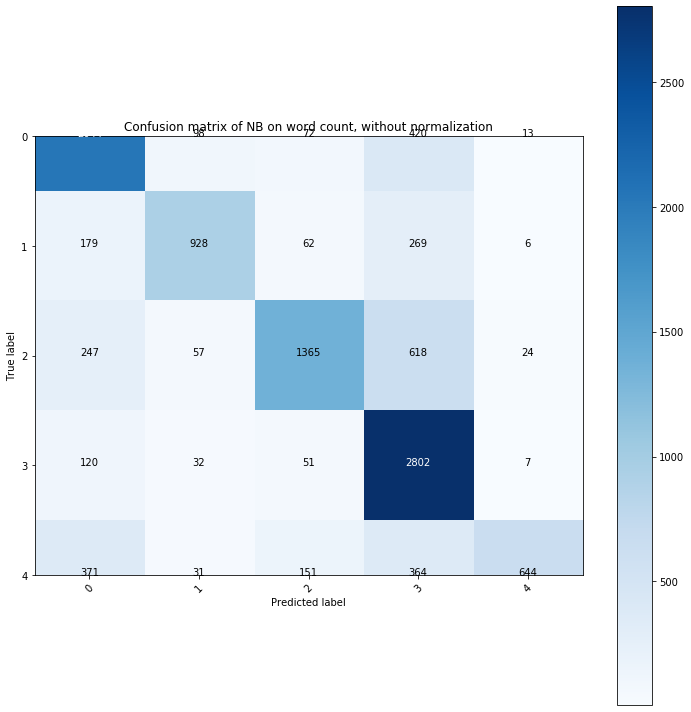

In [22]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3, 4],
                      title='Confusion matrix of NB on word count, without normalization')
plt.show()

In [23]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = CountVectorizer(ngram_range=(1,7), analyzer='char')
tfidf_vec.fit(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)
for dev_index, val_index in skf.split(train_X,train_y):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_cvec_char_0"] = pred_train[:,0]
train_df["nb_cvec_char_1"] = pred_train[:,1]
train_df["nb_cvec_char_2"] = pred_train[:,2]
train_df["nb_cvec_char_3"] = pred_train[:,3]
train_df["nb_cvec_char_4"] = pred_train[:,4]
test_df["nb_cvec_char_0"] = pred_full_test[:,0]
test_df["nb_cvec_char_1"] = pred_full_test[:,1]
test_df["nb_cvec_char_2"] = pred_full_test[:,2]
test_df["nb_cvec_char_3"] = pred_full_test[:,3]
test_df["nb_cvec_char_4"] = pred_full_test[:,4]

Mean cv score :  5.796932719675679


In [24]:
### Fit transform the tfidf vectorizer ###
tfidf_vec = TfidfVectorizer(ngram_range=(1,5), analyzer='char')
full_tfidf = tfidf_vec.fit_transform(train_df['text'].values.tolist() + test_df['text'].values.tolist())
train_tfidf = tfidf_vec.transform(train_df['text'].values.tolist())
test_tfidf = tfidf_vec.transform(test_df['text'].values.tolist())

cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)
for dev_index, val_index in skf.split(train_X,train_y):
    dev_X, val_X = train_tfidf[dev_index], train_tfidf[val_index]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    pred_val_y, pred_test_y, model = runMNB(dev_X, dev_y, val_X, val_y, test_tfidf)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("Mean cv score : ", np.mean(cv_scores))
pred_full_test = pred_full_test / 5.

# add the predictions as new features #
train_df["nb_tfidf_char_0"] = pred_train[:,0]
train_df["nb_tfidf_char_1"] = pred_train[:,1]
train_df["nb_tfidf_char_2"] = pred_train[:,2]
train_df["nb_tfidf_char_3"] = pred_train[:,3]
train_df["nb_tfidf_char_4"] = pred_train[:,4]
test_df["nb_tfidf_char_0"] = pred_full_test[:,0]
test_df["nb_tfidf_char_1"] = pred_full_test[:,1]
test_df["nb_tfidf_char_2"] = pred_full_test[:,2]
test_df["nb_tfidf_char_3"] = pred_full_test[:,3]
test_df["nb_tfidf_char_4"] = pred_full_test[:,4]

Mean cv score :  1.8064948478325236


In [25]:
n_comp = 20
svd_obj = TruncatedSVD(n_components=n_comp, algorithm='arpack')
svd_obj.fit(full_tfidf)
train_svd = pd.DataFrame(svd_obj.transform(train_tfidf))
test_svd = pd.DataFrame(svd_obj.transform(test_tfidf))

train_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
test_svd.columns = ['svd_char_'+str(i) for i in range(n_comp)]
train_df = pd.concat([train_df, train_svd], axis=1)
test_df = pd.concat([test_df, test_svd], axis=1)
del full_tfidf, train_tfidf, test_tfidf, train_svd, test_svd

In [30]:
sub_train = pd.DataFrame(columns=[0, 1, 2, 3, 4])
sub_train.insert(0, 'index', train_df.index)
sub_test = pd.DataFrame(columns=[0, 1, 2, 3, 4])
sub_test.insert(0, 'index', test_df.index)

train_X = train_df.drop(cols_to_drop+['author'], axis=1)
test_X = test_df.drop(cols_to_drop, axis=1)

skf = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=2020)
cv_scores = []
pred_full_test = 0
pred_train = np.zeros([train_df.shape[0], 5])
for dev_index, val_index in skf.split(train_X, train_y):
    print(" =============== new cv starts =============== ")
    dev_X, val_X = train_X.iloc[dev_index], train_X.iloc[val_index]
    dev_y, val_y = train_y.iloc[dev_index], train_y.iloc[val_index]
    pred_val_y, pred_test_y, model = runXGB(dev_X, dev_y, val_X, val_y, test_X, seed_val=0, colsample=0.7)
    pred_full_test = pred_full_test + pred_test_y
    pred_train[val_index,:] = pred_val_y
    cv_scores.append(metrics.log_loss(val_y, pred_val_y))
print("cv scores : ", cv_scores)
pred_full_test = pred_full_test / 5.

sub_train[0] = pred_train[:,0]
sub_train[1] = pred_train[:,1]
sub_train[2] = pred_train[:,2]
sub_train[3] = pred_train[:,3]
sub_train[4] = pred_train[:,4]
sub_test[0] = pred_full_test[:,0]
sub_test[1] = pred_full_test[:,1]
sub_test[2] = pred_full_test[:,2]
sub_test[3] = pred_full_test[:,3]
sub_test[4] = pred_full_test[:,4]

sub_train.to_csv('submission2_train.csv', index=False)
sub_test.to_csv('submission2_test.csv', index=False)

[0]	train-mlogloss:1.44296	test-mlogloss:1.44954
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 50 rounds.
[20]	train-mlogloss:0.511157	test-mlogloss:0.58885
[40]	train-mlogloss:0.361268	test-mlogloss:0.485631
[60]	train-mlogloss:0.301851	test-mlogloss:0.461149
[80]	train-mlogloss:0.262173	test-mlogloss:0.451832
[100]	train-mlogloss:0.227562	test-mlogloss:0.446496
[120]	train-mlogloss:0.199379	test-mlogloss:0.443731
[140]	train-mlogloss:0.176483	test-mlogloss:0.441859
[160]	train-mlogloss:0.156377	test-mlogloss:0.44125
[180]	train-mlogloss:0.138221	test-mlogloss:0.441073
[200]	train-mlogloss:0.122059	test-mlogloss:0.442093
[220]	train-mlogloss:0.109492	test-mlogloss:0.44284
Stopping. Best iteration:
[177]	train-mlogloss:0.140571	test-mlogloss:0.4409

[0]	train-mlogloss:1.44245	test-mlogloss:1.44853
Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will tr

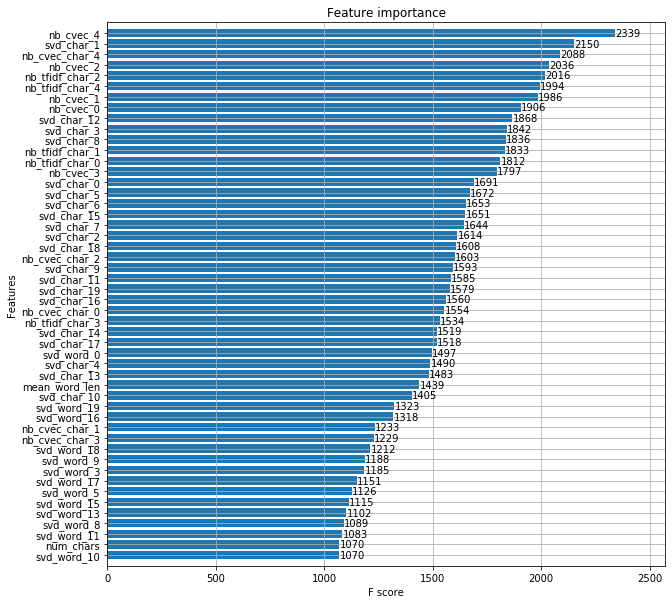

In [33]:
### Plot the important variables ###
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

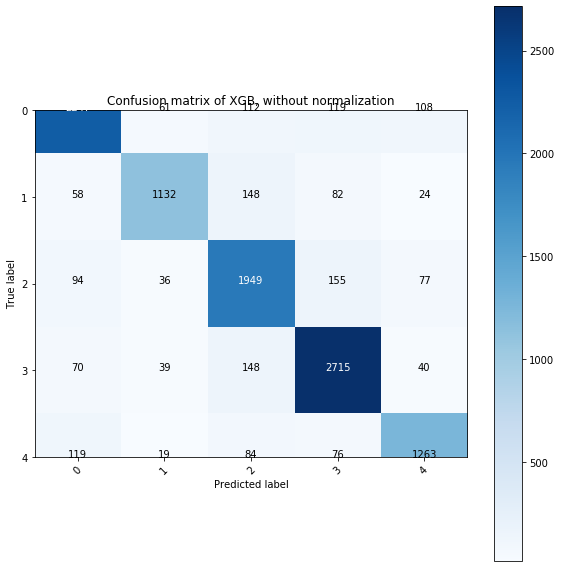

In [34]:
cnf_matrix = confusion_matrix(val_y, np.argmax(pred_val_y,axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=[0, 1, 2, 3, 4],
                      title='Confusion matrix of XGB, without normalization')
plt.show()

In [ ]:
# https://www.kaggle.com/sudalairajkumar/simple-feature-engg-notebook-spooky-author